In [73]:
# Install dependencies
!pip install torchio nibabel matplotlib

In [74]:
# Clone the GitHub repository\n"
!git clone https://github.com/ConfidenceRaymond/LMICsQ-Sim.git
%cd LMICsQ-Sim

# Download Colormap
!curl -s -o colormap.txt https://raw.githubusercontent.com/thenineteen/Semiology-Visualisation-Tool/master/slicer/Resources/Color/BrainAnatomyLabelsV3_0.txt

Cloning into 'LMICsQ-Sim'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 52 (delta 24), reused 39 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 425.40 KiB | 22.39 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/LMICsQ-Sim


In [72]:
#!rm -rf LMICsQ-Sim
#!ls

In [78]:
# Imports
import torch
import numpy as np
import json, os
import torchio as tio
import matplotlib.pyplot as plt
from degrade_mri import get_degradation_pipeline, get_individual_transforms, degrade_mri, save_history_to_json

In [79]:
#@title Visualization functions
def get_bounds(self):
    """Get image bounds in mm.

    Returns:
        np.ndarray: [description]
    """
    first_index = 3 * (-0.5,)
    last_index = np.array(self.spatial_shape) - 0.5
    first_point = nib.affines.apply_affine(self.affine, first_index)
    last_point = nib.affines.apply_affine(self.affine, last_index)
    array = np.array((first_point, last_point))
    bounds_x, bounds_y, bounds_z = array.T.tolist()
    return bounds_x, bounds_y, bounds_z

def to_pil(image):
    from PIL import Image
    from IPython.display import display
    data = image.numpy().squeeze().T
    data = data.astype(np.uint8)
    image = Image.fromarray(data)
    w, h = image.size
    display(image)
    print()  # in case multiple images are being displayed

def stretch(img):
    p1, p99 = np.percentile(img, (1, 99))
    from skimage import exposure
    img_rescale = exposure.rescale_intensity(img, in_range=(p1, p99))
    return img_rescale

def show_slices(
        subject,
        to_ras=False,
        stretch_slices=True,
        indices=None,
        intensity_name='image',
        parcellation=True,
        ):
    subject = tio.ToCanonical()(subject) if to_ras else subject
    def flip(x):
        return np.rot90(x)
    fig, axes = plt.subplots(1, 3, figsize=(12, 8))
    if indices is None:
        half_shape = torch.Tensor(subject.spatial_shape) // 2
        i, j, k = half_shape.long()
        i -= 5  # use a better slice
    else:
        i, j, k = indices
    bounds_x, bounds_y, bounds_z = get_bounds(subject.image)  ###

    orientation = ''.join(subject.image.orientation)
    if orientation != 'RAS':
        import warnings
        warnings.warn(f'Image orientation should be RAS+, not {orientation}+')

    kwargs = dict(cmap='gray', interpolation='none')
    data = subject[intensity_name].data
    slices = data[0, i], data[0, :, j], data[0, ..., k]
    if stretch_slices:
        slices = [stretch(s.numpy()) for s in slices]
    sag, cor, axi = slices

    axes[0].imshow(flip(sag), extent=bounds_y + bounds_z, **kwargs)
    axes[1].imshow(flip(cor), extent=bounds_x + bounds_z, **kwargs)
    axes[2].imshow(flip(axi), extent=bounds_x + bounds_y, **kwargs)

    # kwargs = dict(interpolation='none')
    # data = subject.seg.data
    # slices = data[0, i], data[0, :, j], data[0, ..., k]
    # if parcellation:
    #     sag, cor, axi = [color_table.colorize(s.long()) if s.max() > 1 else s for s in slices]
    # else:
    #     sag, cor, axi = slices
    # axes[1, 0].imshow(flip(sag), extent=bounds_y + bounds_z, **kwargs)
    # axes[1, 1].imshow(flip(cor), extent=bounds_x + bounds_z, **kwargs)
    # axes[1, 2].imshow(flip(axi), extent=bounds_x + bounds_y, **kwargs)

    plt.tight_layout()


class ColorTable:
    def __init__(self, colors_path):
        self.df = self.read_color_table(colors_path)


    @staticmethod
    def read_color_table(colors_path):
        import pandas as pd
        df = pd.read_csv(
            colors_path,
            sep=' ',
            header=None,
            names=['Label', 'Name', 'R', 'G', 'B', 'A'],
            index_col='Label',
        )
        return df

    def get_color(self, label: int):
        """
        There must be nicer ways of doing this
        """
        try:
            rgb = (
                self.df.loc[label].R,
                self.df.loc[label].G,
                self.df.loc[label].B,
            )
        except KeyError:
            rgb = 0, 0, 0
        return rgb

    def colorize(self, label_map: np.ndarray) -> np.ndarray:
        rgb = np.stack(3 * [label_map], axis=-1)
        for label in np.unique(label_map):
            mask = label_map == label
            color = self.get_color(label)
            rgb[mask] = color
        return rgb

color_table = ColorTable('colormap.txt')

In [172]:
# @title
mri_path = 'Sample_Data/MNI152_T1_2mm_brain.nii.gz'  # Example NIfTI path, adjust as needed

try:
    mri = tio.ScalarImage(mri_path)
except FileNotFoundError:
    print(f"Error: File not found at {mri_path}. Please ensure the path is correct.")
    exit()  # Exit if file is not found.
except Exception as e:
    print(f"Error loading NIfTI file: {e}")
    exit()

# Visualize function
def show_slice(mri, title, ax):
    slice_idx = mri.shape[1] // 2
    ax.imshow(mri.data[0, slice_idx, :, :], cmap='gray')
    ax.set_title(title)
    ax.axis('off')

['Resample(target=3, image_interpolation=linear, label_interpolation=nearest, pre_affine_name=None, scalars_only=False)', 'RandomResample()']
["BiasField(coefficients={'image': [-0.386495441198349, 0.3594934344291687, 0.3334513008594513, 0.304487943649292, 0.37839147448539734, -0.3993591368198395, 0.024436600506305695, 0.40557044744491577, -0.3861575722694397, -0.258473664522171, 0.12572884559631348, -0.22730737924575806, 0.40488868951797485, -0.3685758411884308, 0.1205223947763443, -0.32240161299705505, 0.0433068685233593, 0.18782861530780792, -0.09872191399335861, -0.17309609055519104]}, order={'image': 3})", "Noise(mean={'image': 0.0}, std={'image': 0.12984713912010193}, seed={'image': 366152799})", 'SparseSpatialTransform()']
["Noise(mean={'image': 0.0}, std={'image': 0.09459845721721649}, seed={'image': 777235000})"]
['Resample(target=(9.025627136230469, 2.0, 2.0), image_interpolation=nearest, label_interpolation=nearest, pre_affine_name=None, scalars_only=True)', 'Resample(target

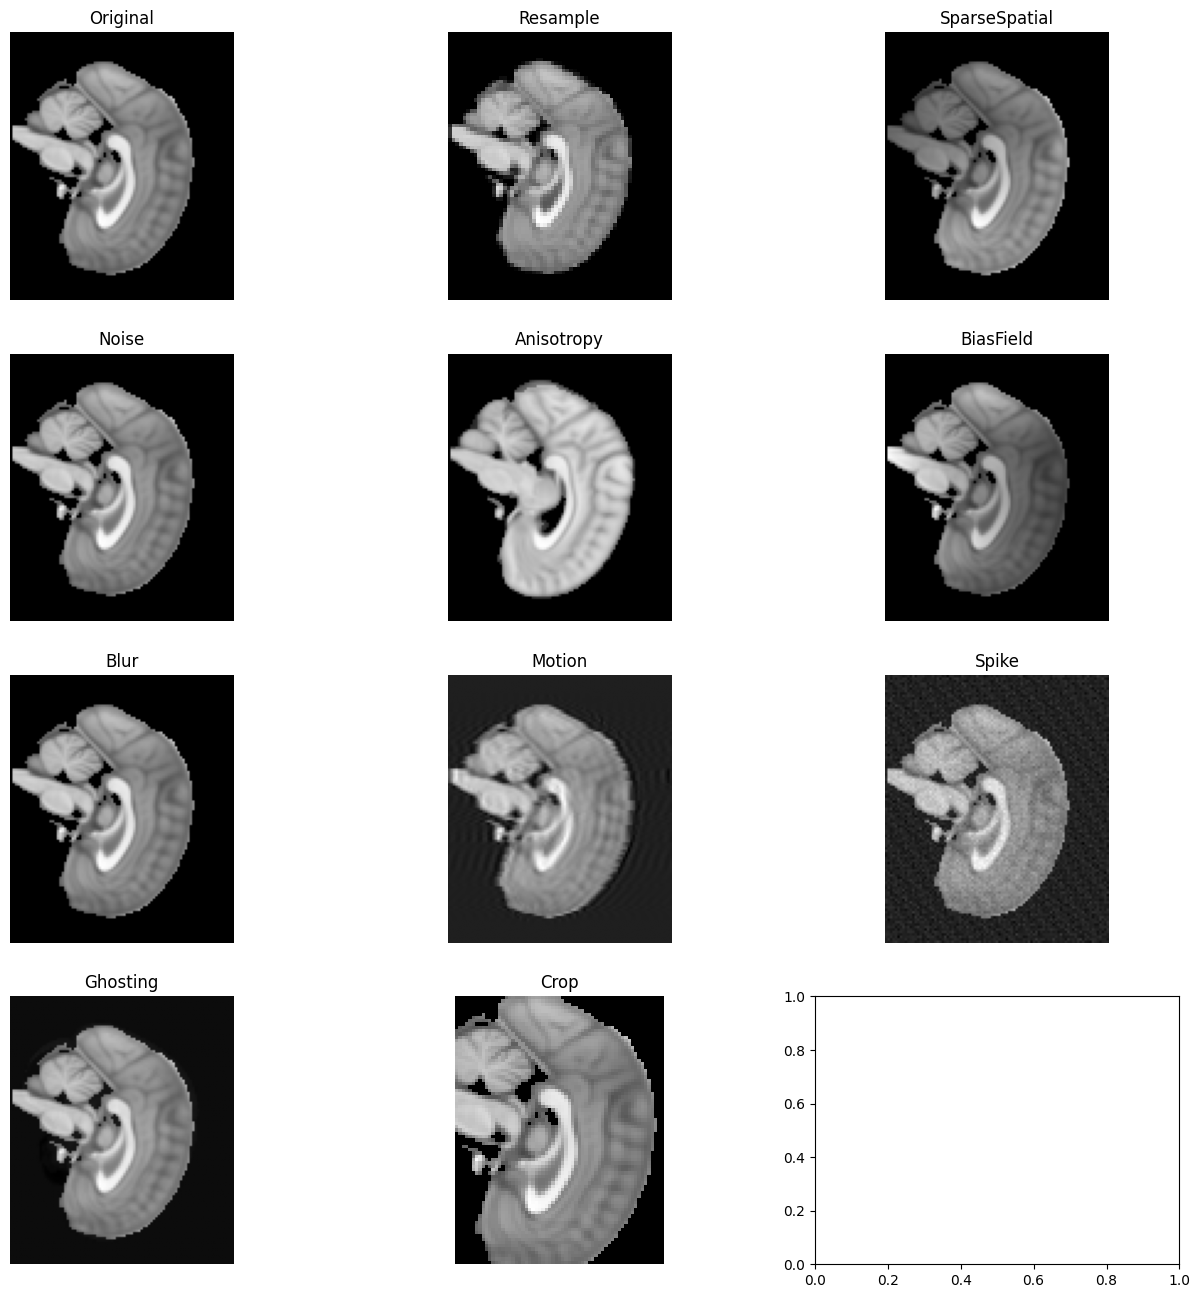

In [174]:
fig, axes = plt.subplots(4, 3, figsize=(16, 16))
axes = axes.flatten()
show_slice(mri, 'Original', axes[0])


# Viewing individual transforms
trans_name =[]
trans_image = []
individual_transforms = get_individual_transforms()
for i, (name, transform) in enumerate(individual_transforms.items(), 1):
    # Transformed images are saved to ouputs
    degraded_mri, _ = degrade_mri(mri_path, f'{name}_degraded.nii.gz', transform)
    trans_image.append(degraded_mri)
    trans_name.append(name)
    print([str(t) for t in degraded_mri.history])
    show_slice(degraded_mri.image, name, axes[i])

Resample
SparseSpatial


<ipython-input-79-e815022550ae>:55: UserWarning: Image orientation should be RAS+, not LAS+
  warnings.warn(f'Image orientation should be RAS+, not {orientation}+')


Noise
Anisotropy
BiasField
Blur
Motion
Spike
Ghosting
Crop


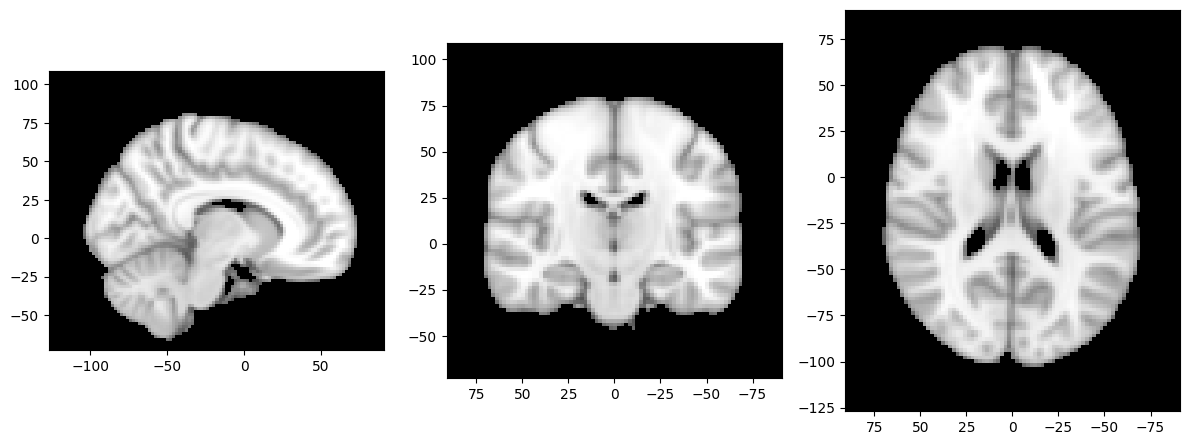

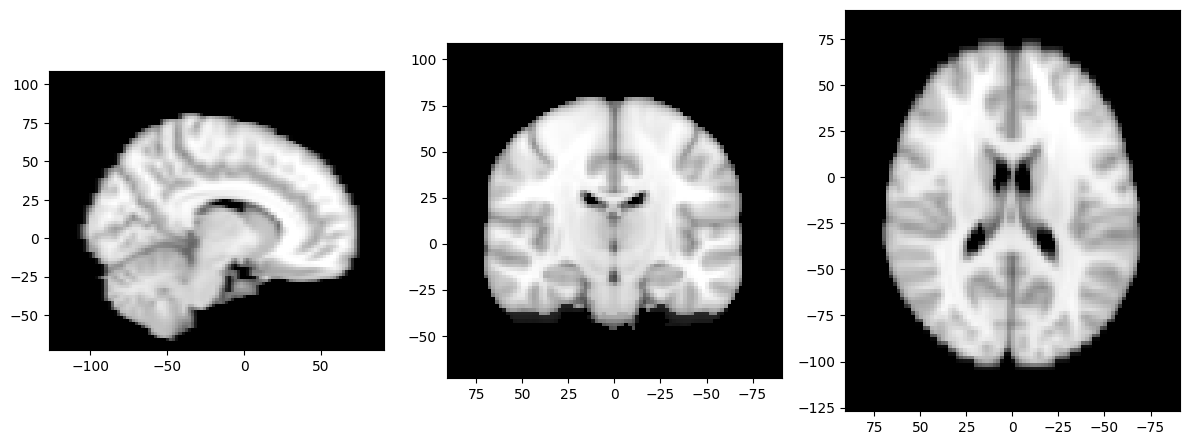

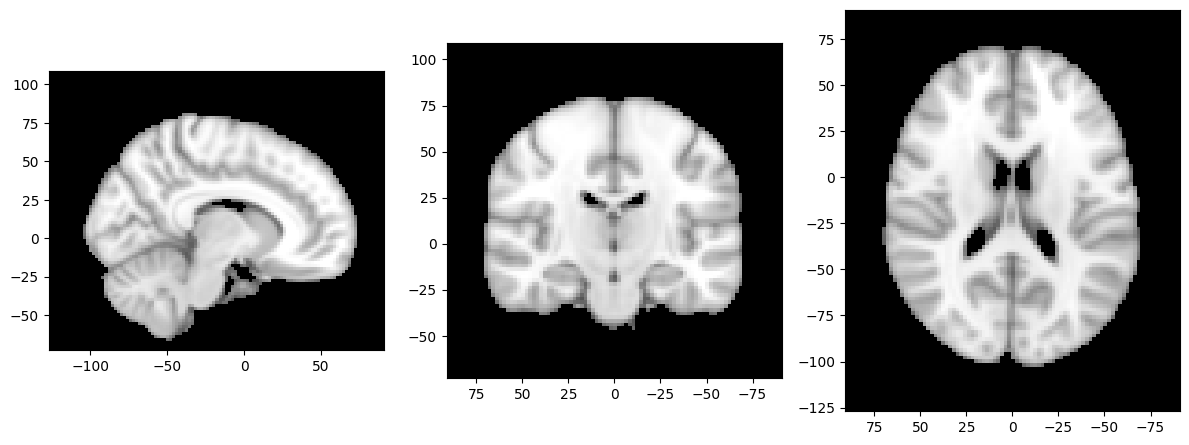

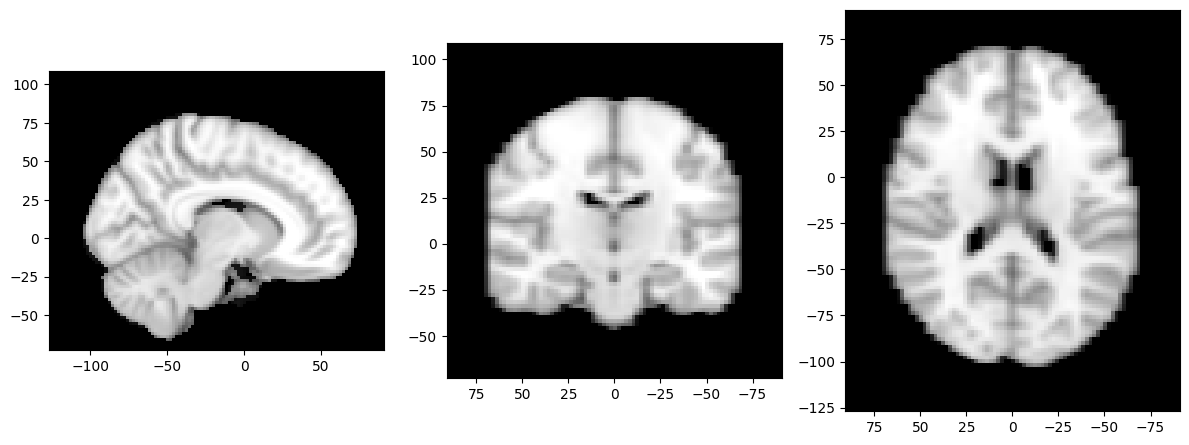

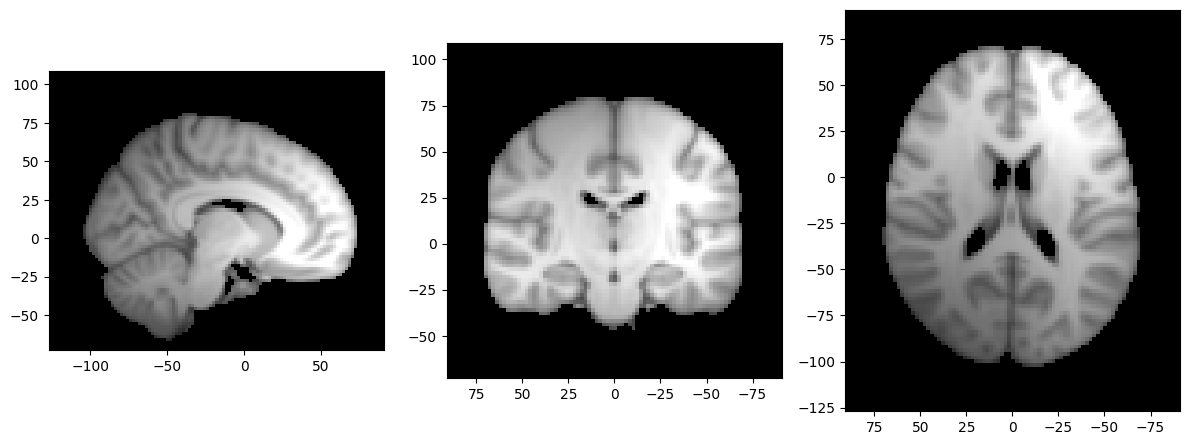

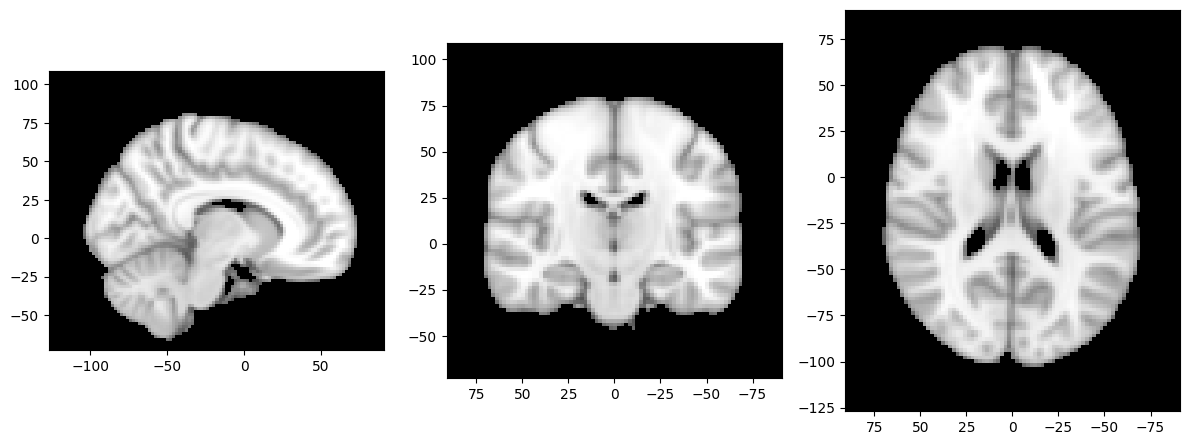

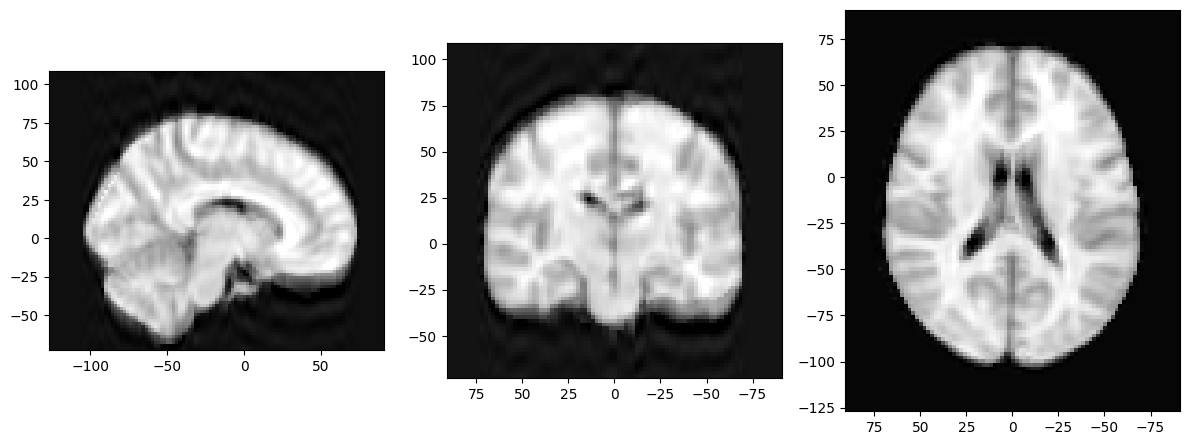

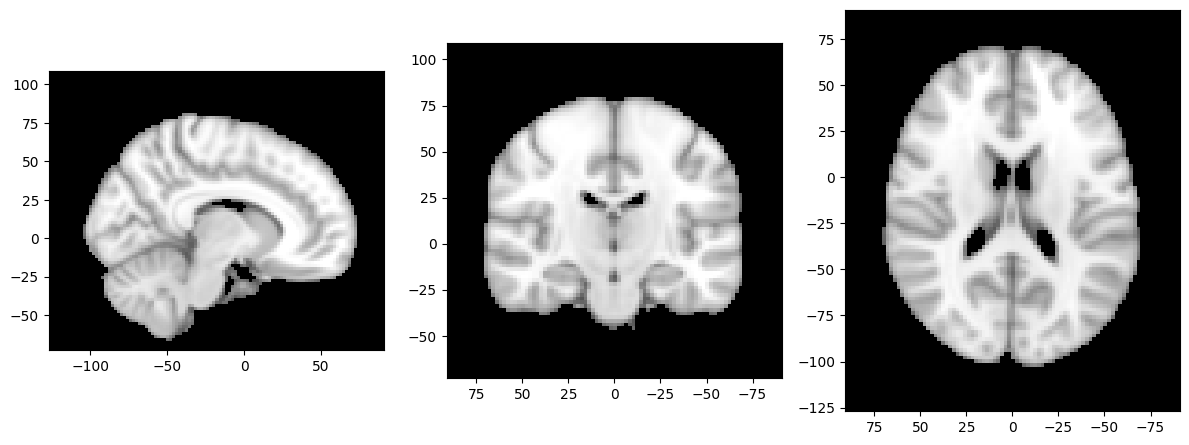

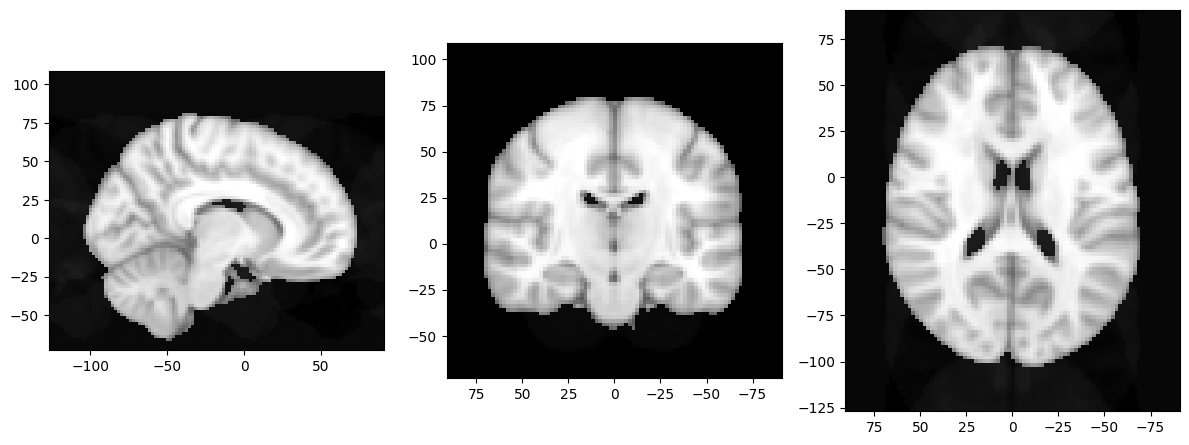

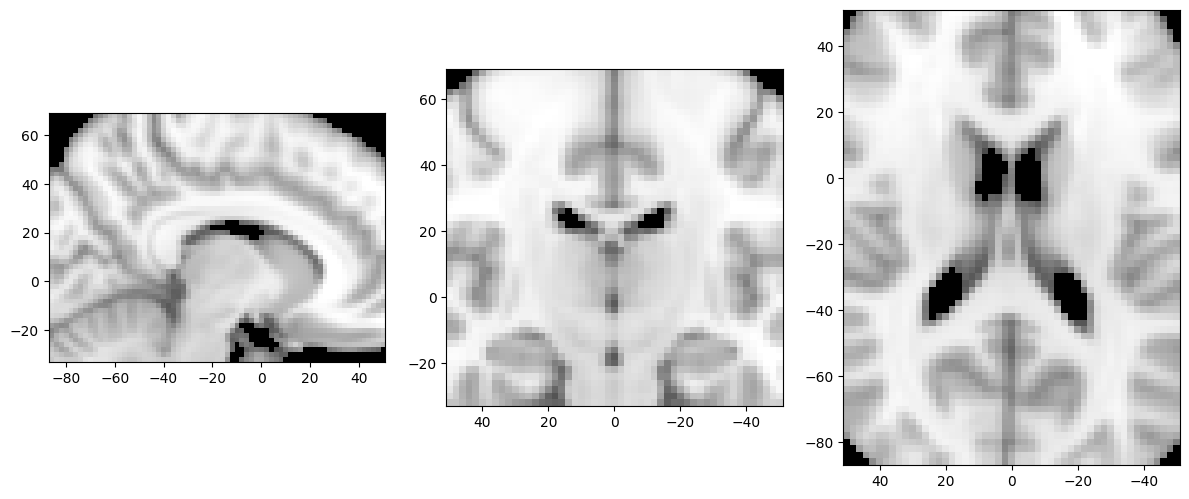

In [120]:
for i, (name, image) in enumerate(zip(trans_name, trans_image)):
    print(name)
    show_slices(image)

['Resample(target=3, image_interpolation=linear, label_interpolation=nearest, pre_affine_name=None, scalars_only=False)', 'RandomResample()', "BiasField(coefficients={'image': [0.12273452430963516, 0.34330976009368896, 0.026499150320887566, -0.14933514595031738, -0.024311484768986702, 0.057891491800546646, -0.12182742357254028, -0.23367978632450104, -0.3531883656978607, -0.05467774346470833, -0.276304692029953, -0.17880281805992126, 0.31780698895454407, -0.11017728596925735, 0.2706601917743683, -0.1416170597076416, 0.3376166820526123, -0.27885520458221436, 0.1626797765493393, -0.019289756193757057]}, order={'image': 3})", 'Resample(target=(7.685146808624268, 3.0, 3.0), image_interpolation=nearest, label_interpolation=nearest, pre_affine_name=None, scalars_only=True)', 'Resample(target=((61, 73, 61), array([[  -3. ,    0. ,    0. ,   89.5],\n       [   0. ,    3. ,    0. , -125.5],\n       [   0. ,    0. ,    3. ,  -71.5],\n       [   0. ,    0. ,    0. ,    1. ]])), image_interpolation

<ipython-input-79-e815022550ae>:55: UserWarning: Image orientation should be RAS+, not LAS+
  warnings.warn(f'Image orientation should be RAS+, not {orientation}+')


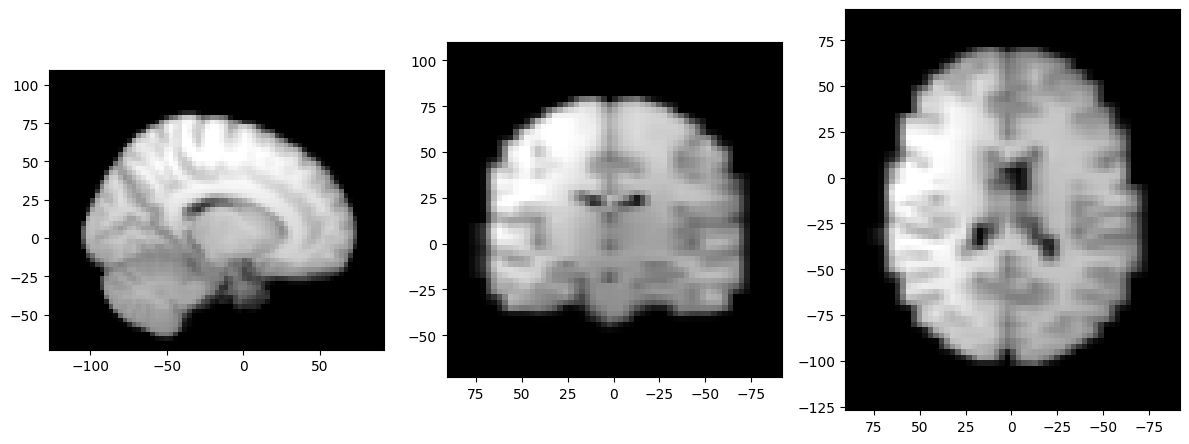

In [127]:
# Full pipeline
pipeline = get_degradation_pipeline()
full_degraded, full_history_path = degrade_mri(mri_path, 'full_degraded.nii', pipeline)
print([str(t) for t in full_degraded.history])
show_slices(full_degraded)

In [131]:
# Display full pipeline history
with open('/content/LMICsQ-Sim/outputs/_history.json', 'r') as f:
    history = json.load(f)
    print('_history:')
    print(json.dumps(history, indent=4))

_history:
{
    "MNI152_T1_2mm_brain.nii.gz": [
        "Resample(target=3, image_interpolation=linear, label_interpolation=nearest, pre_affine_name=None, scalars_only=False)",
        "RandomResample()",
        "BiasField(coefficients={'image': [0.12273452430963516, 0.34330976009368896, 0.026499150320887566, -0.14933514595031738, -0.024311484768986702, 0.057891491800546646, -0.12182742357254028, -0.23367978632450104, -0.3531883656978607, -0.05467774346470833, -0.276304692029953, -0.17880281805992126, 0.31780698895454407, -0.11017728596925735, 0.2706601917743683, -0.1416170597076416, 0.3376166820526123, -0.27885520458221436, 0.1626797765493393, -0.019289756193757057]}, order={'image': 3})",
        "Resample(target=(7.685146808624268, 3.0, 3.0), image_interpolation=nearest, label_interpolation=nearest, pre_affine_name=None, scalars_only=True)",
        "Resample(target=((61, 73, 61), array([[  -3. ,    0. ,    0. ,   89.5],\n       [   0. ,    3. ,    0. , -125.5],\n       [   0. ,   